In [1]:
import torch
import torchvision
import torch.optim as optim
from data.data import get_train_test_loader
from model.network import TeacherNet
import torch.nn.functional as F

/home/kyle/pythonenvs/venv38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [50]:
ds_name = 'mnist'
train_loader, test_loader = get_train_test_loader(ds_name)

### train teacher net

In [51]:
network = TeacherNet()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [52]:
train_losses = []
train_counter = []
test_losses = []
test_accs = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [53]:
def train(epoch, network):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #   epoch, batch_idx * len(data), len(train_loader.dataset),
      #   100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), './results/model.pth')
      # torch.save(optimizer.state_dict(), './results/optimizer.pth')
  return loss

In [54]:
def test(network):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  test_accs.append(100. * correct / len(test_loader.dataset))

In [55]:
test(network)
for epoch in range(1, n_epochs + 1):
  train(epoch, network)
  test(network)

/home/kyle/projects/cs674/magic-m/model/network.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/kyle/pythonenvs/venv38/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3063, Accuracy: 1138/10000 (11%)


Test set: Avg. loss: 0.3636, Accuracy: 8945/10000 (89%)


Test set: Avg. loss: 0.2310, Accuracy: 9327/10000 (93%)


Test set: Avg. loss: 0.1753, Accuracy: 9466/10000 (95%)



### test teacher net using M

In [11]:
class TeacherNet_MGen(torch.nn.Module):
    def __init__(self, teacherNet):
        super(TeacherNet_MGen, self).__init__()
        self.fc1 = teacherNet.fc1
        self.distillable = teacherNet.distillable
        self.fc3 = teacherNet.fc3
        self.distilledLayer = teacherNet

        self.m = []

    def forward(self, x):
        o_1 = torch.reshape(x, (x.shape[0], 28*28))
        o_2 = F.relu(self.fc1(o_1))

        self.o_3_f = self.distillable(o_2).detach() # compute o_3_f in forward pass only

        a = torch.linalg.pinv(o_2)
        self.m = F.linear(a, torch.transpose(self.o_3_f,0 ,1)).detach()
        
        self.o_3 = F.linear(o_2, torch.transpose(self.m,0 ,1)) # propagate loss through here
        o_4 = self.fc3(self.o_3)
        return F.log_softmax(o_4)

In [23]:

mGen = TeacherNet_MGen(network)

In [24]:
test(mGen)

/tmp/ipykernel_1857986/3168701978.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(o_4)



Test set: Avg. loss: 0.1994, Accuracy: 9488/10000 (95%)



### learn task by passing grad thru M (not sequential module) after reinit fc1

In [56]:
train_losses = []
train_counter = []
test_losses = []
test_accs = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [57]:
# freeze weights in distilled layers
for n,p in mGen.named_parameters():
  if not 'fc' in n:
    p.requires_grad = False
  else:
    p.requires_grad = True
    # print(n)

mGen.fc1 = torch.nn.Linear(mGen.fc1.weight.shape[1], mGen.fc1.weight.shape[0]) # randomly reinit fc1
mGen.fc1.requires_grad = True

optimizer = optim.SGD(mGen.parameters(), lr=learning_rate, momentum=momentum)
test(mGen)
for epoch in range(1, n_epochs + 1):
  loss = train(epoch, mGen)
  test(mGen)
  # break


/tmp/ipykernel_1857986/3168701978.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(o_4)



Test set: Avg. loss: 3.4108, Accuracy: 1176/10000 (12%)


Test set: Avg. loss: 0.2177, Accuracy: 9385/10000 (94%)


Test set: Avg. loss: 0.1662, Accuracy: 9527/10000 (95%)


Test set: Avg. loss: 0.1456, Accuracy: 9573/10000 (96%)



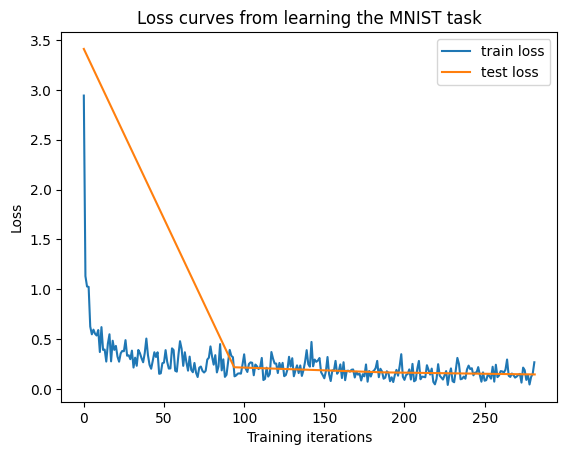

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# print(test_losses)
# print(test_accs)
# create loss plot w test and train loss
e = len(train_loader.dataset) / batch_size_train / 10
# print(e)
plt.title('Loss curves from learning the MNIST task')
plt.ylabel('Loss')
plt.xlabel('Training iterations')

plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(0, len(test_losses)*e, step=e), test_losses)
plt.legend(['train loss', 'test loss'])
plt.show()

# create test acc plot
# plt.plot(np.arange(len(test_accs)), test_accs)
# plt.show()

In [114]:
# check to ensure loss not propagated thru sequential module layers

layers = {
    'fc1' : mGen.fc1.weight.data,
    'fc1b' : mGen.fc1.bias.data,
    'distil0' : mGen.distillable[0].weight.data,
    'distil2' : mGen.distillable[2].weight.data,
    'distil4' : mGen.distillable[4].weight.data,
    'fc3' : mGen.fc3.weight.data,
    'fc3b' : mGen.fc3.bias.data,
}
nf_ct = 0
def getBack(var_grad_fn):
    print(var_grad_fn)
    for n in var_grad_fn.next_functions:
        if n[0]:
            try:
                tensor = getattr(n[0], 'variable')
                print(n[0])
                # print('Tensor with grad found:', tensor)
                found = False
                for k in layers.keys():
                    if tensor.data.shape == layers[k].shape and tensor.data.eq( layers[k]).all():
                        found = True
                        print(k)
                        break
                if not found:
                    nf_ct += 1
                    print('unknown ', tensor.data.shape)
                # print(' - gradient:', tensor.grad)
                print()
            except AttributeError as e:
                getBack(n[0])


getBack(loss.grad_fn)
if nf_ct < 1:
    print('Found all expected tensors in computation graph')

fc3b

fc1b

fc1

fc3

Found all expected tensors in computation graph
